## U-Net Training

In [1]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class KneeSegmentation25D(Dataset):
    def __init__(self, image_dir, mask_dir, filenames):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.filenames = sorted(filenames)

    def __len__(self):
        return len(self.filenames)

    def pad_to_shape(self, img_np, target_shape):
        pad_height = target_shape[0] - img_np.shape[0]
        pad_width = target_shape[1] - img_np.shape[1]
        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left
        return np.pad(img_np, ((pad_top, pad_bottom), (pad_left, pad_right)), mode="constant")

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        study_id, slice_tag = filename.replace(".jpg", "").split("_slice_")
        slice_num = int(slice_tag)

        stack = []
        shapes = []
        for offset in [-1, 0, 1]:
            n = slice_num + offset
            neighbor_file = f"{study_id}_slice_{n:03d}.jpg"
            neighbor_path = os.path.join(self.image_dir, neighbor_file)
            if os.path.exists(neighbor_path):
                img = Image.open(neighbor_path).convert("L")
            else:
                img = Image.open(os.path.join(self.image_dir, filename)).convert("L")

            img_np = np.array(img, dtype=np.float32) / 255.0
            stack.append(img_np)
            shapes.append(img_np.shape)

        max_shape = np.max(shapes, axis=0)
        stack = [self.pad_to_shape(s, max_shape) for s in stack]
        image = np.stack(stack, axis=0)

        mask_path = os.path.join(self.mask_dir, study_id, filename.replace(".jpg", ".npy"))
        mask = np.load(mask_path).astype(np.int64)
        mask = self.pad_to_shape(mask, max_shape)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.long)

# Batch padding to SMP-required divisible-by-32 sizes
def pad_batch_to_32(batch):
    images, masks = zip(*batch)
    h = max(img.shape[1] for img in images)
    w = max(img.shape[2] for img in images)
    def ceil32(x): return ((x + 31) // 32) * 32
    H, W = ceil32(h), ceil32(w)

    padded_imgs, padded_masks = [], []
    for img, mask in zip(images, masks):
        pad = (0, W - img.shape[2], 0, H - img.shape[1])
        padded_imgs.append(F.pad(img, pad))
        padded_masks.append(F.pad(mask, pad))

    return torch.stack(padded_imgs), torch.stack(padded_masks)

In [2]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=5
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [3]:
from sklearn.model_selection import train_test_split
import pickle

image_dir = "/data_vault/hexai/OAICartilage/image_manual_crops"
mask_dir = "/data_vault/hexai/OAICartilage/cropped_annotations_numpy"
all_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

# Split: 80% train, 10% val, 10% test
train_f, temp_f = train_test_split(all_files, test_size=0.2, random_state=42)
val_f, test_f = train_test_split(temp_f, test_size=0.5, random_state=42)

print(f"Train: {len(train_f)} | Val: {len(val_f)} | Test: {len(test_f)}")

train_ds = KneeSegmentation25D(image_dir, mask_dir, train_f)
val_ds = KneeSegmentation25D(image_dir, mask_dir, val_f)
test_ds = KneeSegmentation25D(image_dir, mask_dir, test_f)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=pad_batch_to_32, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=pad_batch_to_32, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, collate_fn=pad_batch_to_32, num_workers=4)

# Save split to a pickle file
split_save_path = "/data_vault/hexai/OAICartilage/knee_split.pkl"
with open(split_save_path, "wb") as f:
    pickle.dump({
        "train": train_f,
        "val": val_f,
        "test": test_f
    }, f)

print(f"✅ Saved split info to: {split_save_path}")

Train: 19702 | Val: 2463 | Test: 2463
✅ Saved split info to: /data_vault/hexai/OAICartilage/knee_split.pkl


In [4]:
from tqdm import tqdm

def iou_score(pred, target, num_classes=5):
    ious = []
    for cls in range(1, num_classes):  # skip background
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()
        ious.append(intersection / union if union != 0 else 1.0)
    return np.mean(ious)

def train_model(epochs=15, save_path="best_model.pth"):
    best_iou = 0.0
    all_epoch_ious = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        print(f"\n Epoch {epoch+1} started...")

        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(x)
            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f" [Epoch {epoch+1}] Avg Training Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_ious = []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                pred = torch.argmax(out, dim=1)
                for p, t in zip(pred, y):
                    val_ious.append(iou_score(p.cpu(), t.cpu()))

        mean_iou = np.mean(val_ious)
        print(f"[Epoch {epoch+1}] Validation IoU: {mean_iou:.4f}")

        # Save best model
        if mean_iou > best_iou:
            best_iou = mean_iou
            torch.save(model.state_dict(), save_path)
            print(f" ✅ Saved best model at Epoch {epoch+1} with IoU={mean_iou:.4f}")
            
        all_epoch_ious.append(mean_iou)

    print(f"\n Training finished. Best IoU: {best_iou:.4f}")
    print(f" Mean Validation IoU across all epochs: {np.mean(all_epoch_ious):.4f}")

In [5]:
train_model(epochs=30)


 Epoch 1 started...


100%|█████████████████████████████| 2463/2463 [03:07<00:00, 13.15it/s]

 [Epoch 1] Avg Training Loss: 0.1276


[Epoch 1] Validation IoU: 0.7314
 ✅ Saved best model at Epoch 1 with IoU=0.7314

 Epoch 2 started...


100%|█████████████████████████████| 2463/2463 [02:44<00:00, 15.01it/s]

 [Epoch 2] Avg Training Loss: 0.0348


[Epoch 2] Validation IoU: 0.7381
 ✅ Saved best model at Epoch 2 with IoU=0.7381

 Epoch 3 started...


100%|█████████████████████████████| 2463/2463 [02:48<00:00, 14.59it/s]

 [Epoch 3] Avg Training Loss: 0.0306


[Epoch 3] Validation IoU: 0.6938

 Epoch 4 started...


100%|█████████████████████████████| 2463/2463 [02:53<00:00, 14.22it/s]

 [Epoch 4] Avg Training Loss: 0.0276


[Epoch 4] Validation IoU: 0.7613
 ✅ Saved best model at Epoch 4 with IoU=0.7613

 Epoch 5 started...


100%|█████████████████████████████| 2463/2463 [02:54<00:00, 14.13it/s]

 [Epoch 5] Avg Training Loss: 0.0255


[Epoch 5] Validation IoU: 0.7700
 ✅ Saved best model at Epoch 5 with IoU=0.7700

 Epoch 6 started...


100%|█████████████████████████████| 2463/2463 [02:53<00:00, 14.16it/s]

 [Epoch 6] Avg Training Loss: 0.0238


[Epoch 6] Validation IoU: 0.7743
 ✅ Saved best model at Epoch 6 with IoU=0.7743

 Epoch 7 started...


100%|█████████████████████████████| 2463/2463 [02:52<00:00, 14.32it/s]

 [Epoch 7] Avg Training Loss: 0.0224


[Epoch 7] Validation IoU: 0.7816
 ✅ Saved best model at Epoch 7 with IoU=0.7816

 Epoch 8 started...


100%|█████████████████████████████| 2463/2463 [02:52<00:00, 14.28it/s]

 [Epoch 8] Avg Training Loss: 0.0213


[Epoch 8] Validation IoU: 0.7839
 ✅ Saved best model at Epoch 8 with IoU=0.7839

 Epoch 9 started...


100%|█████████████████████████████| 2463/2463 [02:54<00:00, 14.13it/s]

 [Epoch 9] Avg Training Loss: 0.0204


[Epoch 9] Validation IoU: 0.7899
 ✅ Saved best model at Epoch 9 with IoU=0.7899

 Epoch 10 started...


100%|█████████████████████████████| 2463/2463 [03:23<00:00, 12.10it/s]

 [Epoch 10] Avg Training Loss: 0.0193


[Epoch 10] Validation IoU: 0.7821

 Epoch 11 started...


100%|█████████████████████████████| 2463/2463 [03:35<00:00, 11.44it/s]

 [Epoch 11] Avg Training Loss: 0.0186


[Epoch 11] Validation IoU: 0.7946
 ✅ Saved best model at Epoch 11 with IoU=0.7946

 Epoch 12 started...


100%|█████████████████████████████| 2463/2463 [03:36<00:00, 11.40it/s]

 [Epoch 12] Avg Training Loss: 0.0176


[Epoch 12] Validation IoU: 0.7968
 ✅ Saved best model at Epoch 12 with IoU=0.7968

 Epoch 13 started...


100%|█████████████████████████████| 2463/2463 [03:20<00:00, 12.29it/s]

 [Epoch 13] Avg Training Loss: 0.0169


[Epoch 13] Validation IoU: 0.7993
 ✅ Saved best model at Epoch 13 with IoU=0.7993

 Epoch 14 started...


100%|█████████████████████████████| 2463/2463 [03:15<00:00, 12.58it/s]

 [Epoch 14] Avg Training Loss: 0.0161


[Epoch 14] Validation IoU: 0.8001
 ✅ Saved best model at Epoch 14 with IoU=0.8001

 Epoch 15 started...


100%|█████████████████████████████| 2463/2463 [03:14<00:00, 12.68it/s]

 [Epoch 15] Avg Training Loss: 0.0155


[Epoch 15] Validation IoU: 0.7995

 Epoch 16 started...


100%|█████████████████████████████| 2463/2463 [03:12<00:00, 12.80it/s]

 [Epoch 16] Avg Training Loss: 0.0148


[Epoch 16] Validation IoU: 0.7981

 Epoch 17 started...


100%|█████████████████████████████| 2463/2463 [03:15<00:00, 12.57it/s]

 [Epoch 17] Avg Training Loss: 0.0146


[Epoch 17] Validation IoU: 0.8034
 ✅ Saved best model at Epoch 17 with IoU=0.8034

 Epoch 18 started...


100%|█████████████████████████████| 2463/2463 [03:11<00:00, 12.84it/s]

 [Epoch 18] Avg Training Loss: 0.0137


[Epoch 18] Validation IoU: 0.8007

 Epoch 19 started...


100%|█████████████████████████████| 2463/2463 [03:13<00:00, 12.75it/s]

 [Epoch 19] Avg Training Loss: 0.0133


[Epoch 19] Validation IoU: 0.8000

 Epoch 20 started...


100%|█████████████████████████████| 2463/2463 [03:13<00:00, 12.75it/s]

 [Epoch 20] Avg Training Loss: 0.0129


[Epoch 20] Validation IoU: 0.8000

 Epoch 21 started...


100%|█████████████████████████████| 2463/2463 [03:13<00:00, 12.71it/s]

 [Epoch 21] Avg Training Loss: 0.0125


[Epoch 21] Validation IoU: 0.7998

 Epoch 22 started...


100%|█████████████████████████████| 2463/2463 [03:13<00:00, 12.72it/s]

 [Epoch 22] Avg Training Loss: 0.0121


[Epoch 22] Validation IoU: 0.8020

 Epoch 23 started...


100%|█████████████████████████████| 2463/2463 [03:12<00:00, 12.79it/s]

 [Epoch 23] Avg Training Loss: 0.0117


[Epoch 23] Validation IoU: 0.7997

 Epoch 24 started...


100%|█████████████████████████████| 2463/2463 [03:15<00:00, 12.59it/s]

 [Epoch 24] Avg Training Loss: 0.0115


[Epoch 24] Validation IoU: 0.8024

 Epoch 25 started...


100%|█████████████████████████████| 2463/2463 [03:17<00:00, 12.48it/s]

 [Epoch 25] Avg Training Loss: 0.0111


[Epoch 25] Validation IoU: 0.8010

 Epoch 26 started...


100%|█████████████████████████████| 2463/2463 [03:20<00:00, 12.26it/s]

 [Epoch 26] Avg Training Loss: 0.0108


[Epoch 26] Validation IoU: 0.8022

 Epoch 27 started...


100%|█████████████████████████████| 2463/2463 [03:13<00:00, 12.76it/s]

 [Epoch 27] Avg Training Loss: 0.0106


[Epoch 27] Validation IoU: 0.8029

 Epoch 28 started...


100%|█████████████████████████████| 2463/2463 [03:15<00:00, 12.63it/s]

 [Epoch 28] Avg Training Loss: 0.0103


[Epoch 28] Validation IoU: 0.8002

 Epoch 29 started...


100%|█████████████████████████████| 2463/2463 [03:15<00:00, 12.62it/s]

 [Epoch 29] Avg Training Loss: 0.0101


[Epoch 29] Validation IoU: 0.8004

 Epoch 30 started...


100%|█████████████████████████████| 2463/2463 [03:13<00:00, 12.74it/s]

 [Epoch 30] Avg Training Loss: 0.0100


[Epoch 30] Validation IoU: 0.7997

 Training finished. Best IoU: 0.8034
 Mean Validation IoU across all epochs: 0.7870


## U-Net Test

In [7]:
# Test
import torch
import numpy as np

# Dice Score Function
def dice_score(pred, target, num_classes=5):
    dices = []
    for cls in range(1, num_classes):  # skip background
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice = (2 * intersection + 1e-6) / (union + 1e-6)
        dices.append(dice.item())
    return np.mean(dices)

# IoU Score Function
def iou_score(pred, target, num_classes=5):
    ious = []
    for cls in range(1, num_classes):  # skip background
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()
        ious.append(intersection / union if union != 0 else 1.0)
    return np.mean(ious)

# Load Best Model
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

# Run Test 
def test_model(test_loader):
    test_ious = []
    test_dices = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = torch.argmax(out, dim=1)
            for p, t in zip(pred, y):
                test_ious.append(iou_score(p.cpu(), t.cpu()))
                test_dices.append(dice_score(p.cpu(), t.cpu()))

    mean_iou = np.mean(test_ious)
    mean_dice = np.mean(test_dices)
    print(f"✅ Test IoU:   {mean_iou:.4f}")
    print(f"✅ Test Dice:  {mean_dice:.4f}")

In [8]:
test_model(test_loader)

✅ Test IoU:   0.8034
✅ Test Dice:  0.8733


## U-Net Visualization

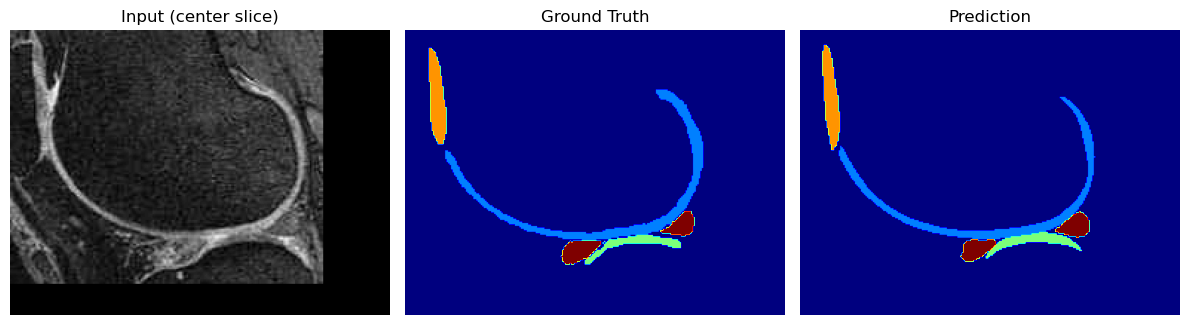

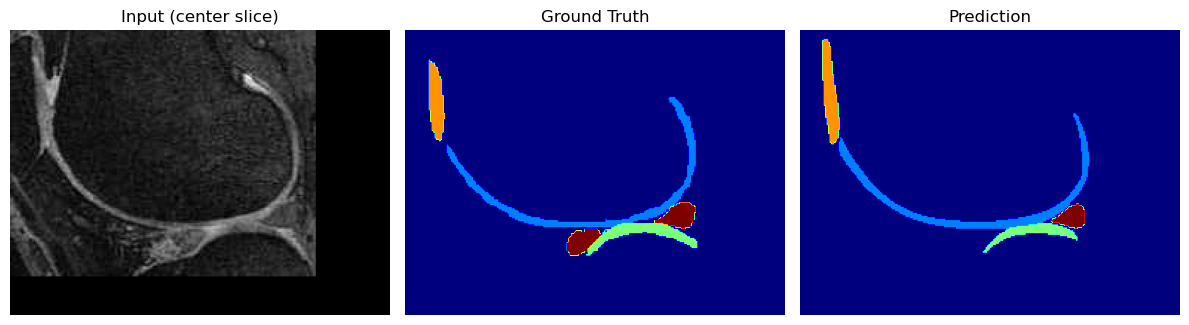

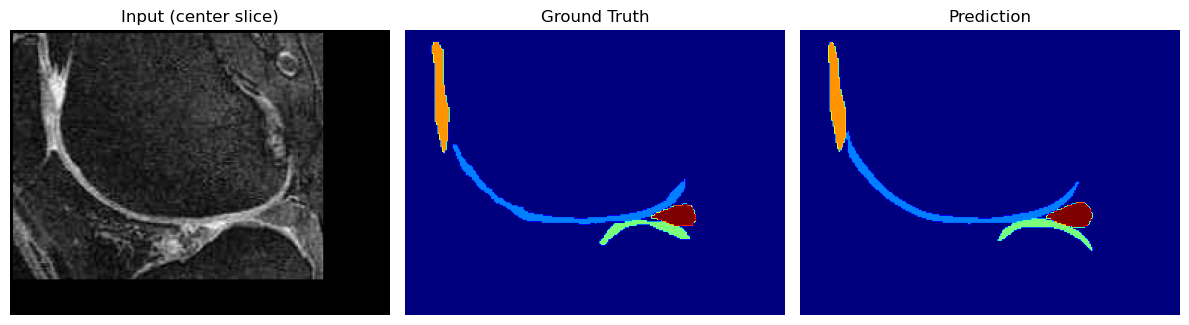

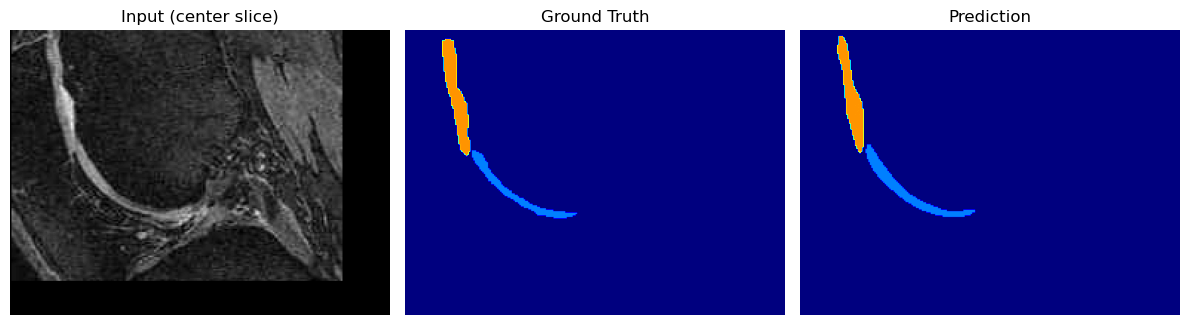

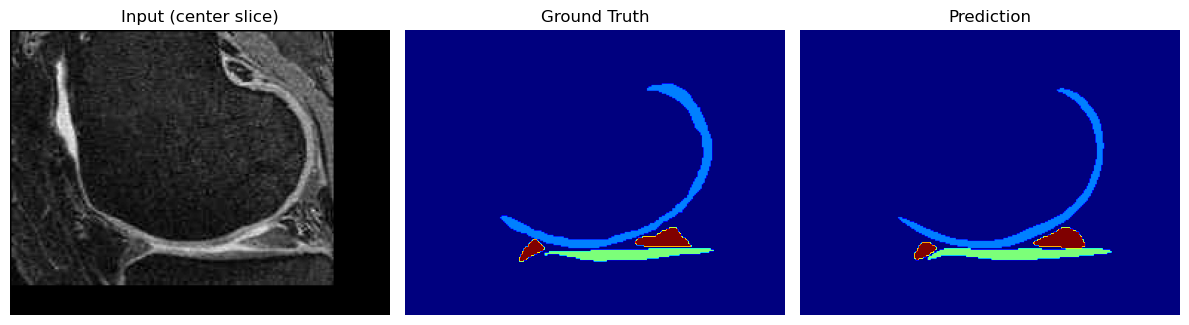

In [6]:
import matplotlib.pyplot as plt

# Load model
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

# 5 random samples from val_loader
samples = list(val_loader)
images, masks = samples[0]  # batch of 8 by default
images = images[:5].to(device)  # take first 5
masks = masks[:5].to(device)

with torch.no_grad():
    preds = model(images)
    preds = torch.argmax(preds, dim=1)  # [B, H, W]

# Plot
for i in range(5):
    img = images[i].cpu().numpy().transpose(1, 2, 0)  # [H, W, 3]
    true_mask = masks[i].cpu().numpy()
    pred_mask = preds[i].cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img[:, :, 1], cmap='gray')  # center slice of 2.5D stack
    axs[0].set_title("Input (center slice)")
    axs[1].imshow(true_mask, cmap='jet', vmin=0, vmax=4)
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_mask, cmap='jet', vmin=0, vmax=4)
    axs[2].set_title("Prediction")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

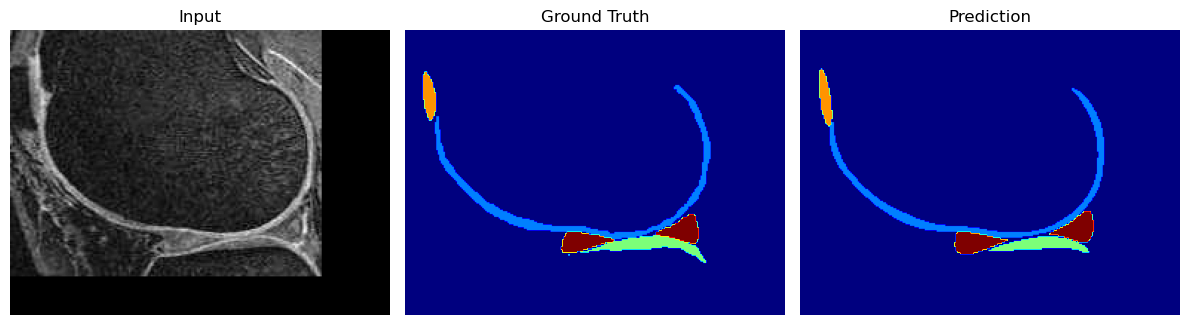

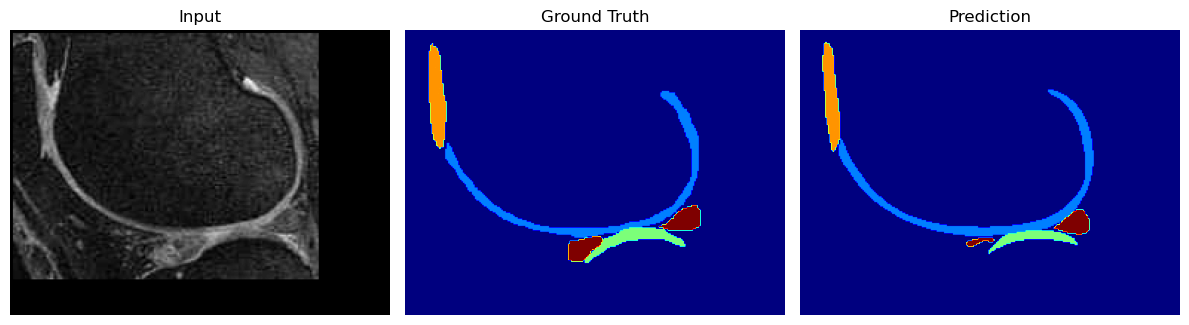

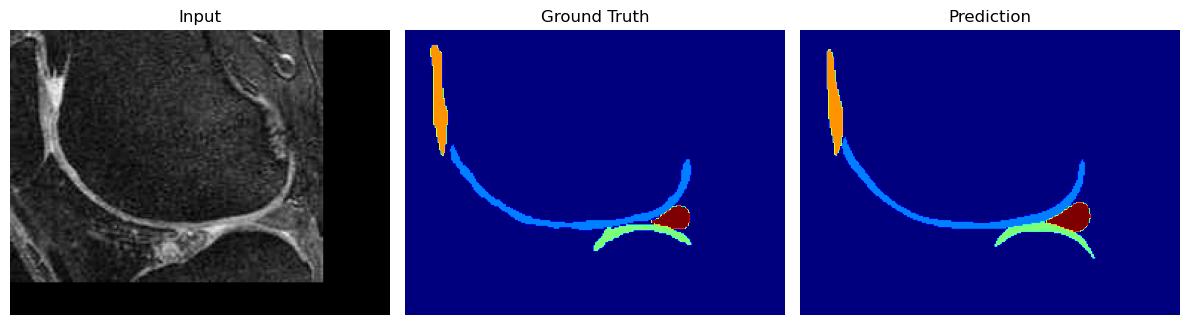

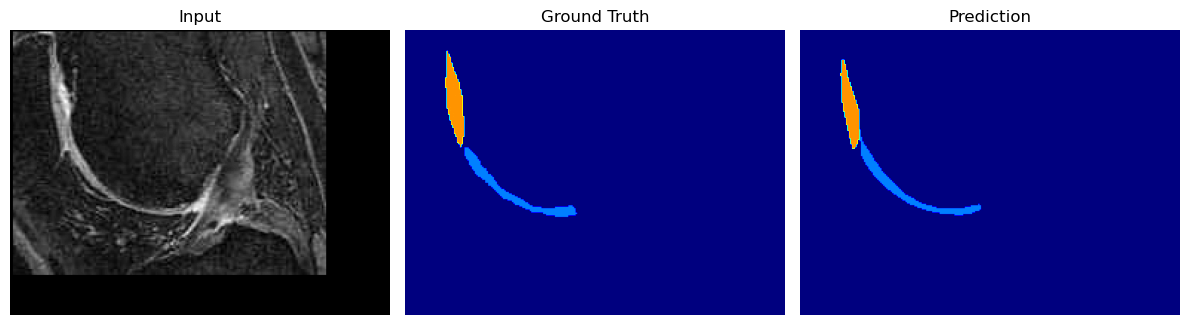

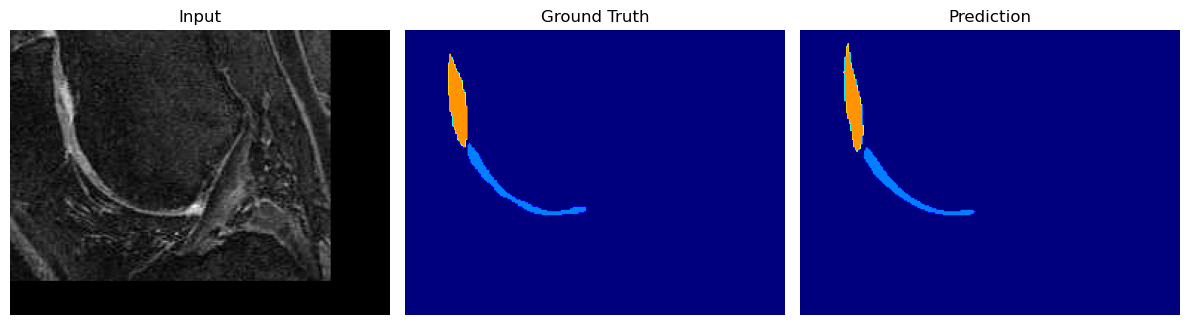

In [11]:
import matplotlib.pyplot as plt

# Load model
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

# 5 random samples from test_loader
samples = list(test_loader)
images, masks = samples[0]  # batch of 8 by default
images = images[:5].to(device)  # take first 5
masks = masks[:5].to(device)

with torch.no_grad():
    preds = model(images)
    preds = torch.argmax(preds, dim=1)  

# Plot
for i in range(5):
    img = images[i].cpu().numpy().transpose(1, 2, 0)  # [H, W, 3]
    true_mask = masks[i].cpu().numpy()
    pred_mask = preds[i].cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img[:, :, 1], cmap='gray')  # center slice of 2.5D stack
    axs[0].set_title("Input")
    axs[1].imshow(true_mask, cmap='jet', vmin=0, vmax=4)
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_mask, cmap='jet', vmin=0, vmax=4)
    axs[2].set_title("Prediction")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

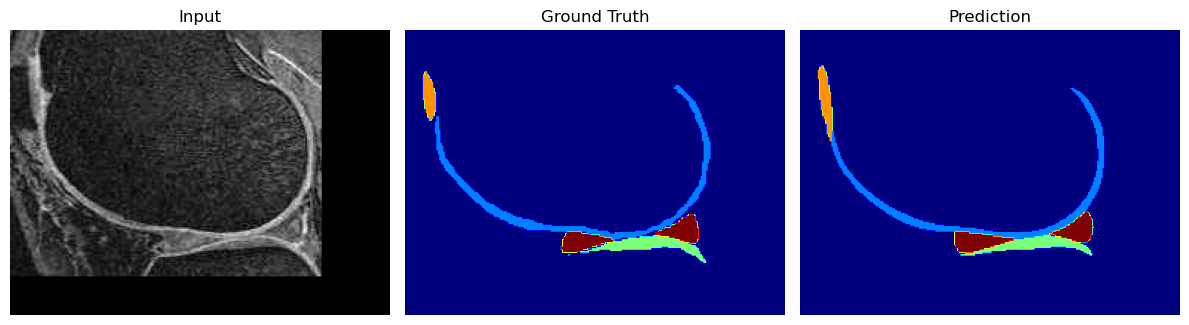

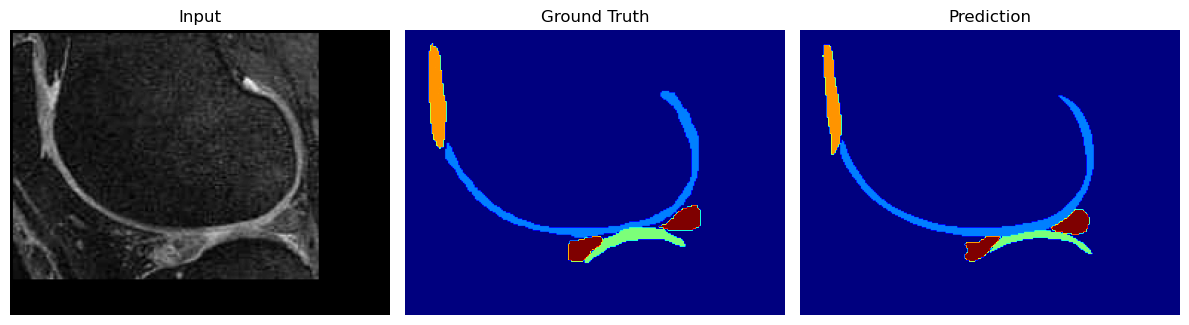

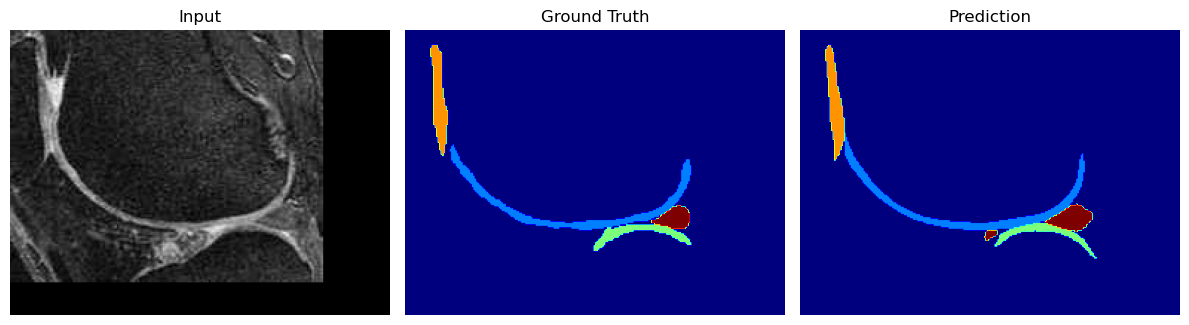

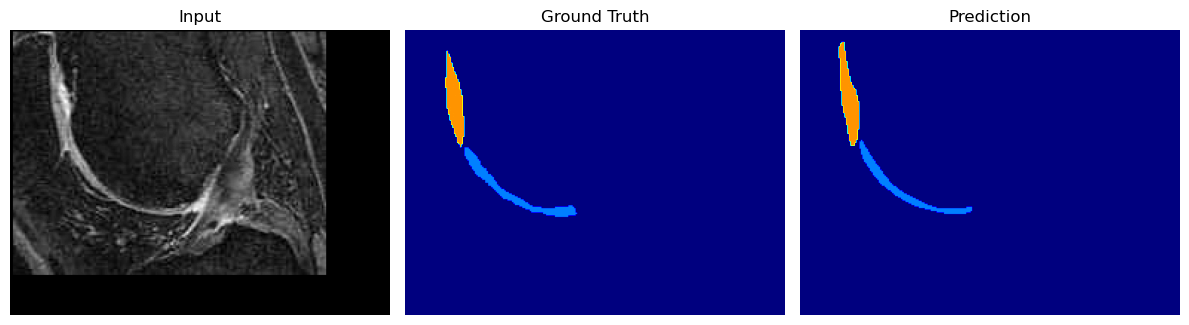

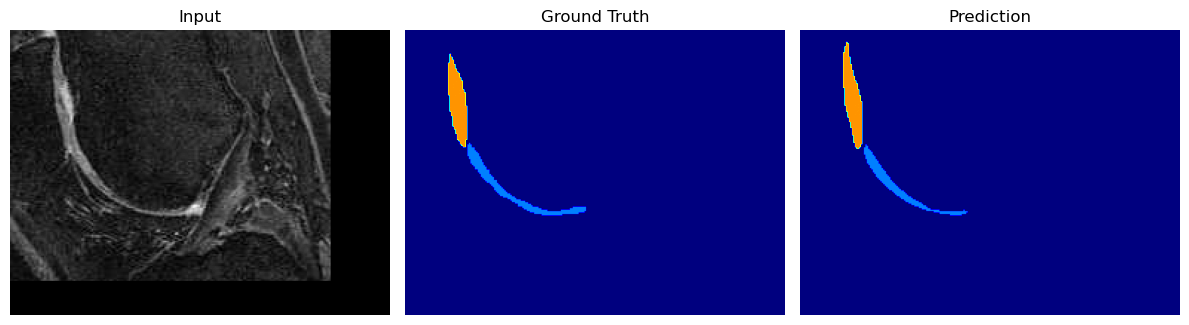

In [20]:
import matplotlib.pyplot as plt

# Load best CSA model
model_2.load_state_dict(torch.load("csa_best_model.pth", map_location=device))
model_2.eval()

# Get a batch from the test loader
test_samples = next(iter(test_loader))
images, masks = test_samples
images = images[:5].to(device)
masks = masks[:5].to(device)

# Inference
with torch.no_grad():
    preds = model_2(images)
    preds = torch.argmax(preds, dim=1)  # [B, H, W]

# Plot predictions vs ground truth
for i in range(5):
    img = images[i].cpu().numpy()[1]  # center slice of the 2.5D stack
    true_mask = masks[i].cpu().numpy()
    pred_mask = preds[i].cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img, cmap="gray")
    axs[0].set_title("Input")

    axs[1].imshow(true_mask, cmap="jet", vmin=0, vmax=4)
    axs[1].set_title("Ground Truth")

    axs[2].imshow(pred_mask, cmap="jet", vmin=0, vmax=4)
    axs[2].set_title("Prediction")

    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()
